In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
sns.set(style="ticks", color_codes=True)
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Snow\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#read data
import gzip
with gzip.open("GameAnalyticsTestData.gz") as f:
    event_df = pd.read_csv(f)
event_df.head(3)

,event_timestamp,event_category,event_id,player_country_code,player_id,player_session_id,transaction_amount,game_build,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue
0,1484053435,design,boot,TR,7a98917fd12ba24ae4d2e42a74b0944c,01l7esFo-5XvS-eyKl-QX5q-UalaTmyM2qz,nan,v1.1.26,1483818916,1484053428,310,nan
1,1484416837,design,boot,IT,20fbf618e34215d876965b6304134ce3,03PPdJ8G-Hn6V-5zwl-xRZx-3k06wnFhxqH,nan,v1.1.26,1484416849,1484416835,14,nan
2,1484148932,design,boot,NaN,c44c05baf6f019241780cca1947e8cc2,03qZsL5V-m8MH-ybBT-PX6w-K83AOfIWnek,nan,v1.1.28,1482771340,1484148925,8783,nan


In [3]:
#convert event timestamp to datetime & creating event day_of_week
event_df["day_of_week"] = pd.to_datetime(event_df["event_timestamp"],unit='s').dt.day_name()

In [4]:
#drop unnecessary fields for modelling
event_df.drop(["player_id","player_session_id","event_timestamp","player_first_install_timestamp","session_start_ts"], axis=1, inplace=True)

In [5]:
event_df.head(5)

,event_category,event_id,player_country_code,transaction_amount,game_build,session_duration_seconds,player_cumulative_revenue,day_of_week
0,design,boot,TR,nan,v1.1.26,310,nan,Tuesday
1,design,boot,IT,nan,v1.1.26,14,nan,Saturday
2,design,boot,NaN,nan,v1.1.28,8783,nan,Wednesday
3,design,boot,AU,nan,v1.1.26,247,396.00,Friday
4,design,boot,IN,nan,v1.1.26,178,nan,Wednesday


In [6]:
#check missing value
print(event_df.isnull().sum())

event_category                    0
event_id                          0
player_country_code           31435
transaction_amount           827920
game_build                        0
session_duration_seconds          0
player_cumulative_revenue    790011
day_of_week                       0
dtype: int64


In [7]:
#data handling: imput missing value 
event_df=event_df.dropna(axis=0, subset=['transaction_amount']) 
event_df=event_df.fillna(0)
print(event_df.isnull().sum())

event_category               0
event_id                     0
player_country_code          0
transaction_amount           0
game_build                   0
session_duration_seconds     0
player_cumulative_revenue    0
day_of_week                  0
dtype: int64


In [8]:
event_df.describe()

,transaction_amount,session_duration_seconds,player_cumulative_revenue
count,"22,089.00","22,089.00","22,089.00"
mean,"7,182.01","6,333.73","267,130.72"
std,"3,685.55","35,692.31","446,334.34"
min,99.00,0.00,99.00
25%,"3,699.00",525.00,"39,996.00"
50%,"9,999.00","1,182.00","109,989.00"
75%,"9,999.00","2,380.00","277,470.00"
max,"9,999.00","1,365,834.00","7,247,265.00"


Session_duration_seconds have a nonsense max value. It seems like we have some outliers.

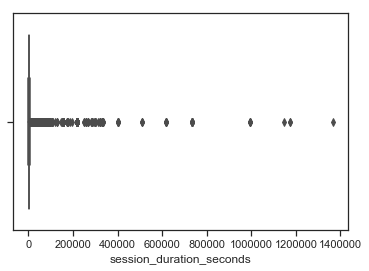

In [9]:
sns.boxplot(x=event_df['session_duration_seconds'])

In [10]:
#Exclude outliers
event_df=event_df[~(np.abs(event_df["session_duration_seconds"]-event_df["session_duration_seconds"].mean()) > (3*event_df["session_duration_seconds"].std()))]
event_df=event_df[~(np.abs(event_df["player_cumulative_revenue"]-event_df["player_cumulative_revenue"].mean()) > (3*event_df["player_cumulative_revenue"].std()))]
event_df.describe()

,transaction_amount,session_duration_seconds,player_cumulative_revenue
count,"21,287.00","21,287.00","21,287.00"
mean,"7,189.76","4,028.77","204,402.08"
std,"3,698.62","11,816.30","266,952.09"
min,99.00,7.00,99.00
25%,"3,699.00",506.00,"37,993.00"
50%,"9,999.00","1,133.00","100,189.00"
75%,"9,999.00","2,336.00","249,975.00"
max,"9,999.00","105,961.00","1,569,843.00"


This method to exclude outliers is not successfull as I expected. But again since limited time I can't spend more time for it.

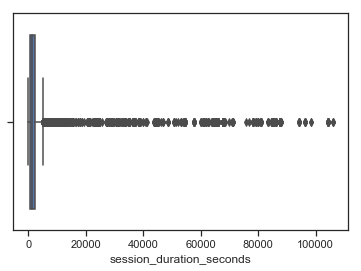

In [11]:
sns.boxplot(x=event_df['session_duration_seconds'])

In [12]:
#Check categorical data values
print("Number of Unique event id: %d" %event_df['event_id'].nunique())
event_df['event_id'].value_counts()

Number of Unique event id: 29


Monetize:Buy:buycandy6               7547
Monetize:Buy:buycash6                5515
Monetize:Buy:buybundlehighroller     4172
Monetize:Buy:buybundlemotormayhem     819
Monetize:Buy:buybundle1               764
Monetize:Buy:buycandy1                637
Monetize:Buy:buycash1                 361
Monetize:Buy:buycandy2                311
Monetize:Buy:buycandy3                198
Monetize:Buy:buycash5                 108
Monetize:Buy:buycandy5                104
Monetize:Buy:buycash2                 102
Monetize:Buy:buycash4                  89
Monetize:Buy:buycandy4                 88
Monetize:Buy:buycash3                  88
Monetize:Buy:buyCandy6                 85
Monetize:Buy:buyCash6                  60
Monetize:Buy:buyCandy2                 56
Monetize:Buy:buyCandy1                 43
Monetize:Buy:buyCandy3                 34
Monetize:Buy:buyCash1                  26
Monetize:Buy:buyBundleHighRoller       23
Monetize:Buy:buyBundle1                17
Monetize:Buy:buyCash2             

There are same events but they had written different, so to be fixed as follow.

In [13]:
#data handling: converting all event_id names to lower case and merging the same categories
event_df['event_id']=event_df['event_id'].str.lower()
print("Number of Unique event id: %d" %event_df['event_id'].nunique())
event_df['event_id'].value_counts()

Number of Unique event id: 15


monetize:buy:buycandy6               7632
monetize:buy:buycash6                5575
monetize:buy:buybundlehighroller     4195
monetize:buy:buybundlemotormayhem     829
monetize:buy:buybundle1               781
monetize:buy:buycandy1                680
monetize:buy:buycash1                 387
monetize:buy:buycandy2                367
monetize:buy:buycandy3                232
monetize:buy:buycash2                 113
monetize:buy:buycash5                 108
monetize:buy:buycandy5                106
monetize:buy:buycandy4                 95
monetize:buy:buycash3                  95
monetize:buy:buycash4                  92
Name: event_id, dtype: int64

In [14]:
#check data field game_build
event_df['game_build'].value_counts()

v1.1.26    20903
v1.1.28      384
Name: game_build, dtype: int64

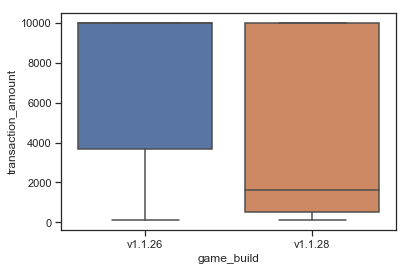

In [15]:
#boxplot for game_build&transaction_amount
sns.boxplot(x="game_build", y="transaction_amount", data=event_df)

(array([1.26576993e-04, 5.69418524e-05, 3.87916370e-05, 9.26491390e-05,
        2.21835967e-05, 0.00000000e+00, 9.83433243e-05, 0.00000000e+00,
        0.00000000e+00, 4.97648064e-04, 0.00000000e+00, 0.00000000e+00,
        2.53865759e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.56673134e-03]),
 array([  99.,  495.,  891., 1287., 1683., 2079., 2475., 2871., 3267.,
        3663., 4059., 4455., 4851., 5247., 5643., 6039., 6435., 6831.,
        7227., 7623., 8019., 8415., 8811., 9207., 9603., 9999.]),
 <a list of 25 Patch objects>)

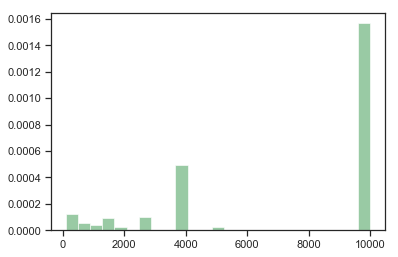

In [16]:
s=event_df[event_df["transaction_amount"]!=0]
plt.hist(s["transaction_amount"], bins=25, density=True, alpha=0.6, color='g')

In [17]:
#check transaction_amount field
event_df["transaction_amount"].value_counts().sort_index()

99.00         680
199.00        387
499.00        480
999.00        327
1,599.00      781
1,998.00      187
2,499.00      829
3,699.00     4195
4,999.00      214
9,999.00    13207
Name: transaction_amount, dtype: int64

In [18]:
#Categorize in Low and High Class
event_df["transaction_amount"]=pd.cut(event_df['transaction_amount'], bins=[99, 3699, 9999], include_lowest=True, labels=['low', 'high'])
event_df["transaction_amount"].value_counts()

high    13421
low      7866
Name: transaction_amount, dtype: int64

In [19]:
#categoric field in dataset
categorical_df = event_df.select_dtypes(include=['object']).copy()
categorical_df.columns

Index(['event_category', 'event_id', 'player_country_code', 'game_build',
       'day_of_week'],
      dtype='object')

In [20]:
#preprocessing 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
event_df["player_country_code"] = le.fit_transform(event_df["player_country_code"].astype(str))
event_df["event_category"] = le.fit_transform(event_df["event_category"].astype(str))
event_df["event_id"] = le.fit_transform(event_df["event_id"].astype(str))
event_df["game_build"] = le.fit_transform(event_df["game_build"].astype(str))

event_df.head(5)

,event_category,event_id,player_country_code,transaction_amount,game_build,session_duration_seconds,player_cumulative_revenue,day_of_week
172,0,4,70,low,0,1327,"4,196.00",Thursday
636,0,9,51,low,0,3826,398.00,Monday
637,0,9,51,low,0,3826,199.00,Monday
638,0,9,51,low,0,3826,597.00,Monday
639,0,9,51,low,0,3826,796.00,Monday


In [21]:
event_df["day_of_week"] = le.fit_transform(event_df["day_of_week"].astype(str))

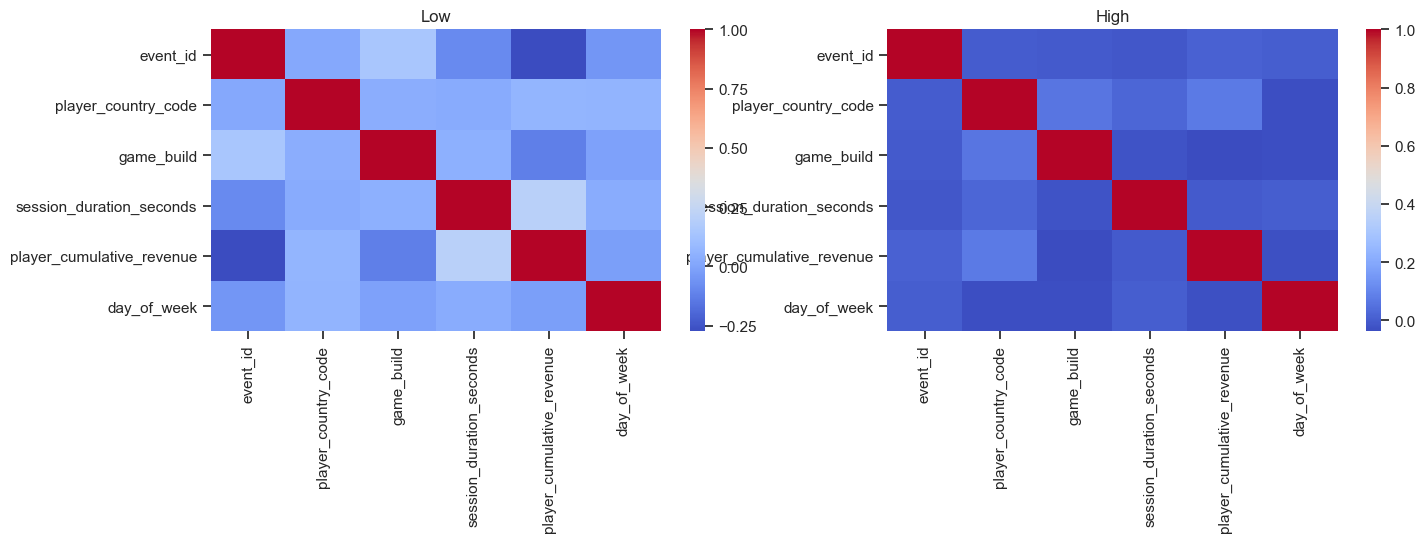

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(event_df[event_df['transaction_amount']=='low'][['event_id','player_country_code','game_build',
       'session_duration_seconds', 'player_cumulative_revenue','day_of_week']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Low')

ax = sns.heatmap(event_df[event_df['transaction_amount']=='high'][['event_id','player_country_code','game_build',
       'session_duration_seconds', 'player_cumulative_revenue','day_of_week']].corr(), ax = axes[1], cmap='coolwarm')
ax = ax.set_title('High')

As we understand from heatmaps above, there is no relationship between the given fields and amount category. More data is needed for an accurate modelling.

In [23]:
event_df["transaction_amount"] = le.fit_transform(event_df["transaction_amount"].astype(str))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(event_df, event_df['transaction_amount'], test_size=0.33)

In [25]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 76.09
Time consumed for training: 0.025 seconds
Time consumed for prediction: 0.04759 seconds


In [26]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 100.00
Time consumed for training: 0.063 seconds
Time consumed for prediction: 0.00694 seconds


It is not normal to have an 100% occuracy. I think, more data manipulation is needed but time is limited.
Also I just tried 2 models for sample. Normally I would try others like SVN, xgboost.
Cross validation and feature importance need to be looked.